# Leaf Classification---Kaggle competition (Part II)

For this ipython notebook, I will investigate the problem about how to perform feature reductions. The investigation is developed as follows:

1. The correlation of features and how to visulize them
2. The PCA and feature reduction

## 1. The correlation of features and how to visulize them

Here, another thanks for the Author of the notebook: https://www.kaggle.com/asparago/3-basic-classifiers-and-features-correlation Federico C

### 1.1 Using Naive Bayes for revealing the feature correlation

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import tensorflow as tf

# Python visulization
import matplotlib.pyplot as plt
import seaborn as sns
import pyecharts as pchart
import matplotlib.image as mpimg 
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

## Modelling Algorithms
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

## Model preprocess
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit

# %matplotlib notebook
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

/Users/charliedang/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
## Import dataset and define the train and test set

import os

## PATH name definition
PATH = os.getcwd()
IMAGES = PATH + "/images"
TRAIN = PATH + "/train.csv"
TEST = PATH + "/test.csv"
SAMPLE = PATH + "sample_submission.csv"

## Get the dataset from the file
df = pd.read_csv(TRAIN, sep = ',')
df_test = pd.read_csv(TEST, sep = ',')

## Label encoder
label_fitter = LabelEncoder().fit(df['species'])
labels = label_fitter.transform(df['species'])
test_ids = df_test.id

## Now let's drop the unimportant features
df = df.drop(['species', 'id'], axis = 1)
df_test = df_test.drop(['id'], axis = 1)

## Using stratifiedShuffleSplit to split train and test dataset
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
sss.get_n_splits(df, labels)
      
for train_index, test_index in sss.split(df, labels):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = df.iloc[train_index], df.iloc[test_index]
    Y_train, Y_test = labels[train_index], labels[test_index]

In [3]:
## Define Naive Bayes
NBC = MultinomialNB()

NBC.fit(X_train, Y_train)

name = NBC.__class__.__name__

train_predictions = NBC.predict(X_test)
acc_train = accuracy_score(Y_train, NBC.predict(X_train))
acc = accuracy_score(Y_test, train_predictions)

print ("The training set accuracy is: " + str(acc_train*100)+'%')
print ("The test set accuracy is: " + str(acc*100)+'%')

The training set accuracy is: 78.15656565656566%
The test set accuracy is: 75.25252525252525%


**Conclusion:**

The similar score between the training accuracy and test accuracy proves the point that training and testing dataset obey the same statistical distribution. So the train, test splitting method works quite well in our case. But the low accuracy points out one thing that the assumption of the independent probability is not viable for this dataset

### 1.2 The calculation of Pearson coefficient

The features are evenly distributed among the three big categories

In [4]:
import re

## Check the categories in the columns
# nameset = set(re.match(r'([a-z]+)([0-9]+)',i).groups()[0] for i in df.columns)

## Alternative solutions
nameset = np.unique([re.match(r'([a-z]+)([0-9]+)',i).groups()[0] for i in df.columns])

print (nameset)

['margin' 'shape' 'texture']


In [5]:
## build category names:

margin_names = [name for name in df.columns if re.match(r'([a-z]+)([0-9]+)',name).groups()[0] == nameset[0]]
shape_names = [name for name in df.columns if re.match(r'([a-z]+)([0-9]+)',name).groups()[0] == nameset[1]]
texture_names = [name for name in df.columns if re.match(r'([a-z]+)([0-9]+)',name).groups()[0] == nameset[2]]

In [6]:
import Pdprint as pp

## Build Pearson number within and out category

# 1. Within class
margin_pearson = [pp.Pearson(df[margin_names[i]], df[margin_names[i+1]]) for i in range(len(margin_names)-1)]
margin_x = [0]*len(margin_pearson)
shape_pearson = [pp.Pearson(df[shape_names[i]], df[shape_names[i+1]]) for i in range(len(shape_names)-1)]
shape_x = [1]*len(shape_pearson)
texture_pearson = [pp.Pearson(df[texture_names[i]], df[texture_names[i+1]]) for i in range(len(texture_names)-1)]
texture_x = [2]*len(texture_pearson)

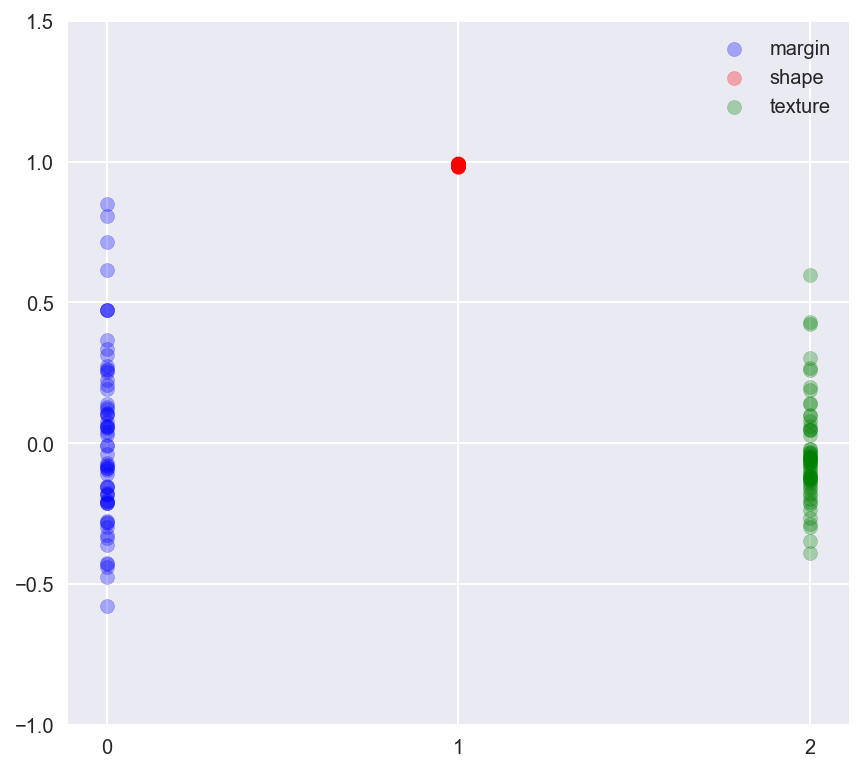

In [19]:
## plot the distribution of Pearson number
sns.set()  ## set seaborn style

fig, ax = plt.subplots(figsize = (7,7))

ax.scatter(margin_x, margin_pearson, color = 'blue', alpha= 0.3, label = "margin")
ax.scatter(shape_x, shape_pearson, color = 'red', alpha = 0.3, label = "shape")
ax.scatter(texture_x, texture_pearson, color = 'green', alpha = 0.3, label = "texture")
ax.legend()

## set axes geometry
ax.set_ylim(-1,1.5)
ax.set_xticks([0,1,2])
ax.set_label(['margin, shape, texture'])

ax.set_aspect(0.8)
plt.show()